# Solve cartpole with DQN



In [1]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import deque
from collections import namedtuple
from itertools import count
from PIL import Image
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


env = gym.make('CartPole-v0').unwrapped

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
class ReplayMemory(object):
    def __init__(self, capacity):
        self.cap = capacity
        self.index = 0
        self.memory = []
    
    def add(self, *args):
        if len(self.memory) < self.cap:
            self.memory.append([*args])
        else:
            self.memory[self.index] = [*args]
            self.index += 1
            self.index = self.index % self.cap
    
    def sample(self, batch_size):
        batch = random.sample(self.memory, batch_size)
        return [*zip(*batch)]
    
    def count(self):
        return len(self.memory)
RMtest = ReplayMemory(4)
for i in range(5):
    RMtest.add(i,i,0,i+5)
RMtest.sample(4)

[(4, 1, 2, 3), (4, 1, 2, 3), (0, 0, 0, 0), (9, 6, 7, 8)]

(40, 150, 3)


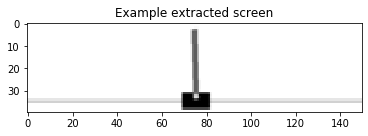

In [3]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])


def get_cart_location(screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART

def get_screen():
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. Transpose it into torch order (CHW).
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    # Cart is in the lower half, so strip off the top and bottom of the screen
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0).to(device)[:,2:3,:,:] # we only care about hte lbue component atm


env.reset()
plt.figure()
grayscale = [get_screen().cpu().squeeze(0).numpy()]*3
grayscale = np.rollaxis(np.concatenate(grayscale),0,3)
print(grayscale.shape)
plt.imshow(grayscale, interpolation='none')
plt.title('Example extracted screen')
plt.show()

In [4]:
class DQN(nn.Module):
    """Deep Q-network with target network"""
    
    def __init__(self, n_outputs, learning_rate):
        super(DQN, self).__init__()
        # network
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1)
        self.conv3 = nn.Conv2d(16, 4, kernel_size=3, stride=1)
        
        self.pool = nn.MaxPool2d(2)

        self.head = nn.Linear(204, n_outputs)
        self.optimizer = optim.RMSprop(self.parameters(), lr=learning_rate)
    
    def forward(self, x):
        x = F.relu(self.pool(self.conv1(x)))
        x = F.relu(self.pool(self.conv2(x)))
        x = F.relu(self.pool(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))
    
    def loss(self, q_outputs, q_targets):
        return F.smooth_l1_loss(q_targets, q_outputs)
    
    def update_params(self, new_params, tau):
        params = self.state_dict()
        for k in params.keys():
            params[k] = (1-tau) * params[k] + tau * new_params[k]
        self.load_state_dict(params)

class DQN_basic(nn.Module):
    def __init__(self, outputs, lr):
        super(DQN_basic, self).__init__()
        self.l1 = nn.Linear(4, 20)
        self.l2 = nn.Linear(20, 20)
        self.head = nn.Linear(20, outputs)
        
        self.optimizer = optim.RMSprop(self.parameters(), lr=learning_rate)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        return self.head(x)
    
    def loss(self, q_outputs, q_targets):
        return F.smooth_l1_loss(q_targets, q_outputs)
    
    def update_params(self, new_params, tau):
        params = self.state_dict()
        for k in params.keys():
            params[k] = (1-tau) * params[k] + tau * new_params[k]
        self.load_state_dict(params)

In [48]:
# train Deep Q-network

num_episodes = 800
episode_limit = 400

batch_size = 128
learning_rate = 0.001

gamma = 0.75
epsilon = 1.0
epsilon_min = 0.05

tau = 0.01
TARGET_UPDATE = 20

replay_memory_capacity = 40000
prefill_memory = batch_size
prefill_memory = min(prefill_memory, replay_memory_capacity)
val_freq = 20 

EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
steps_done = 0
n_outputs = env.action_space.n

# initialize DQN and replay memory
policy_dqn = DQN(n_outputs, learning_rate).to(device)
target_dqn = DQN(n_outputs, learning_rate).to(device)
target_dqn.load_state_dict(policy_dqn.state_dict())

replay_memory = ReplayMemory(replay_memory_capacity)
env.close()
# prefill replay memory with random actions
if prefill_memory > 0:
    print('prefill replay memory')
    s = env.reset()
    #s = torch.from_numpy(s).float().to(device)
    screen = get_screen()
    state = [screen]*3
    s = torch.cat(state, dim=1)
    
    while replay_memory.count() < prefill_memory:
        a = env.action_space.sample()
        s1 , r, d, _ = env.step(a)
        #s1 = torch.from_numpy(s1).float().to(device)
        
        s1 = get_screen()
        state.append(s1)
        del state[0]
        s1 = torch.cat(state, dim=1)
            
        replay_memory.add(s, a, r, s1, d)
        if not d:
            s = s1
        else:
            env.reset()

# training loop
try:
    print('start training')
    rewards, lengths, losses, epsilons = [], [], [], []
    for i in range(num_episodes):
        print(i)
        s = env.reset()
        #s = torch.from_numpy(s).float().to(device)
        ep_reward = ep_loss = 0
        screen = get_screen()
        state = [screen]*3
        s = torch.cat(state, dim=1)
        for j in range(episode_limit):
            env.render()
            # select action with epsilon-greedy strategy
            epsilon = EPS_END + (EPS_START - EPS_END) * \
                math.exp(-1. * steps_done / EPS_DECAY)
            steps_done += 1
            if np.random.rand() < epsilon:
                a = env.action_space.sample()
            else:
                with torch.no_grad():
                    a = policy_dqn(s).argmax().item()
                    
            s1, r, d, _ = env.step(a)
            screen = get_screen()
            state.append(screen)
            del state[0]
            s1 = torch.cat(state, dim=1)
            #s1 = torch.from_numpy(s1).float().to(device)
            
            replay_memory.add(s, a, r, s1, d)
            
            
            if replay_memory.count() >= batch_size:
                ss, aa, rr, ss1, dd = replay_memory.sample(batch_size)
                ss = torch.cat(ss)
                ss1 = torch.cat(ss1)
                rr = torch.tensor(rr,device=device)
                aa = torch.tensor(aa,device=device).unsqueeze(1)
                dd = torch.tensor(dd,dtype=torch.float32,device=device)
                
                policy_dqn.optimizer.zero_grad()
                Q = policy_dqn(ss).gather(1, aa).squeeze()
                
                with torch.no_grad():
                    Q1 = target_dqn(ss1)
                    
                q_targets = rr + gamma * Q1.max(dim=1)[0] * (1 - dd)
                
                loss = policy_dqn.loss(Q, q_targets)
                loss.backward()
                for param in policy_dqn.parameters():
                    param.grad.data.clamp_(-1, 1)
                policy_dqn.optimizer.step()
                
                ep_loss += loss.item() 
                #target_dqn.update_params(policy_dqn.state_dict(), tau)
            else:
                loss = 0
            
            # bookkeeping
            s = s1
            ep_reward += r
            if d: break
             
        if i % TARGET_UPDATE == 0:
            target_dqn.load_state_dict(policy_dqn.state_dict())
        # bookkeeping
        
        #epsilon *= num_episodes/(i/(num_episodes/20)+num_episodes) # decrease epsilon
        epsilons.append(epsilon); rewards.append(ep_reward); lengths.append(j+1); losses.append(ep_loss)
        if (i+1) % val_freq == 0: print('%5d mean training reward: %5.2f' % (i+1, np.mean(rewards[-val_freq:])))
    print('done')
except KeyboardInterrupt:
    print('interrupt')

prefill replay memory
start training
0
1
2
3
4
5
6
7
interrupt


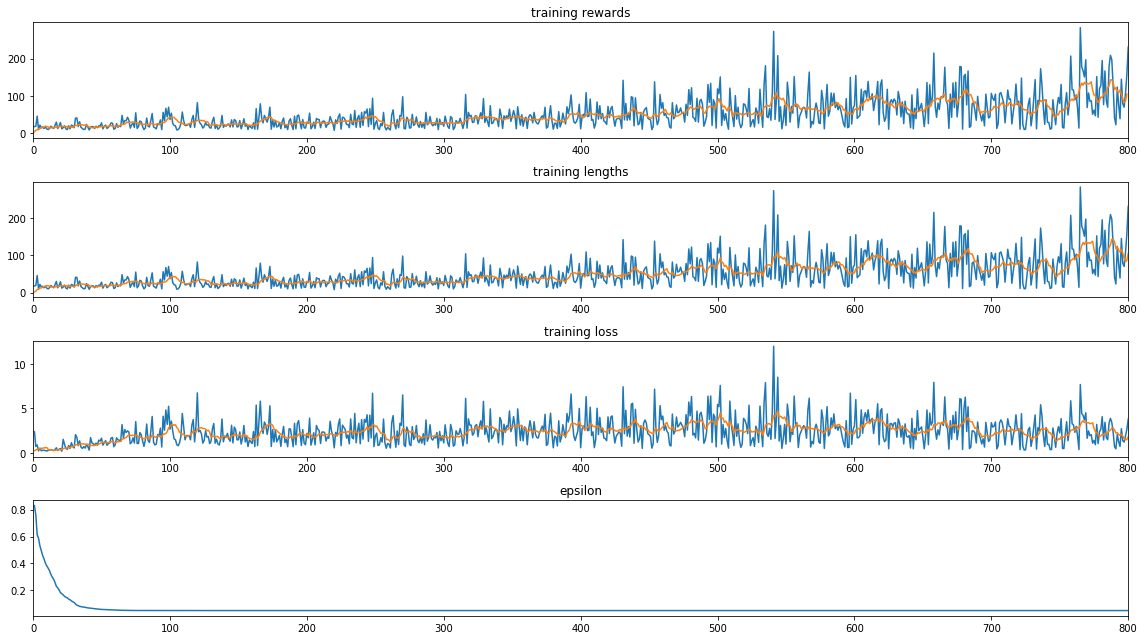

In [10]:
# plot results
def moving_average(a, n=10) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret / n

plt.figure(figsize=(16, 9))
plt.subplot(411)
plt.title('training rewards')
plt.plot(range(1, num_episodes+1), rewards)
plt.plot(moving_average(rewards))
plt.xlim([0, num_episodes])
plt.subplot(412)
plt.title('training lengths')
plt.plot(range(1, num_episodes+1), lengths)
plt.plot(range(1, num_episodes+1), moving_average(lengths))
plt.xlim([0, num_episodes])
plt.subplot(413)
plt.title('training loss')
plt.plot(range(1, num_episodes+1), losses)
plt.plot(range(1, num_episodes+1), moving_average(losses))
plt.xlim([0, num_episodes])
plt.subplot(414)
plt.title('epsilon')
plt.plot(range(1, num_episodes+1), epsilons)
plt.xlim([0, num_episodes])
plt.tight_layout(); plt.show()

NameError: name 'select_action' is not defined

In [ ]:
rr + gamma * Q1.max(dim=1)[0] 

In [ ]:

print(q_targets)
print(Q)
print(loss)
q_targets = rr + gamma * Q1.max(dim=1)[0] * (1 - dd)
diff = (q_targets - Q)
print(diff)

In [ ]:
print(torch.sum(state[0] - state[2]))
print(torch.mean(state[1]))